In [181]:
#1 先导入所需要的程序包
import datetime
import numpy as np
import pandas as pd
import time
from jqdata import *
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import copy
import pickle
import os
import csv

In [208]:
'''
注意：
size选用排序为False
book_to_price_ratio排序为False
roe_ttm选用排序为True
beta选用True
momentum选用True
money_flow_20 选用False
liquidity选用False
Variance60选用False
BIAS60选用False
earnings_yield选用False
financial_expense_rate选用False
turnover_volatility选用False
residual_volatility选用False
leverage选用False
'''

f='leverage'
if (os.path.exists('C:/Users/dsquant06/Desktop/test/'+f)==False):
    os.mkdir('C:/Users/dsquant06/Desktop/test/'+f)
path='C:/Users/dsquant06/Desktop/test/test.csv'

In [209]:

# 定义类'参数分析'
class parameter_analysis(object):
    
    # 定义函数中不同的变量
    def __init__(self, algorithm_id=None):
        self.algorithm_id = algorithm_id            # 回测id
        
        self.params_df = pd.DataFrame()             # 回测中所有调参备选值的内容，列名字为对应修改面两名称，对应回测中的 g.XXXX
        self.results = {}                           # 回测结果的回报率，key 为 params_df 的行序号，value 为
        self.evaluations = {}                       # 回测结果的各项指标，key 为 params_df 的行序号，value 为一个 dataframe
        self.backtest_ids = {}                      # 回测结果的 id
        
        # 新加入的基准的回测结果 id，可以默认为空 ''，则使用回测中设定的基准
        self.benchmark_id = '000300.XSHG'                      
        
        self.benchmark_returns = []                 # 新加入的基准的回测回报率
        self.returns = {}                           # 记录所有回报率
        self.excess_returns = {}                    # 记录超额收益率
        self.log_returns = {}                       # 记录收益率的 log 值
        self.log_excess_returns = {}                # 记录超额收益的 log 值
        self.dates = []                             # 回测对应的所有日期
        self.excess_max_drawdown = {}               # 计算超额收益的最大回撤
        self.excess_annual_return = {}              # 计算超额收益率的年化指标
        self.evaluations_df = pd.DataFrame()        # 记录各项回测指标，除日回报率外
    
    # 定义排队运行多参数回测函数
    def run_backtest(self,                          #
                     algorithm_id=None,             # 回测策略id
                     running_max=10,                # 回测中同时巡行最大回测数量
                     start_date='2009-04-12',                   # 回测开始时间
                     end_date='2017-01-01',                     # 回测结束日期
                     frequency='day',               # 回测的运行频率
                     initial_cash='100000000',        # 回测的初始持仓金额
                     param_names=[],                # 回测中调整参数涉及的变量
                     param_values=[]                # 回测中每个变量的备选参数值
                     ):
        # 当此处回测策略的 id 没有给出时，调用类输入的策略 id
        if algorithm_id == None: algorithm_id=self.algorithm_id
        
        # 生成所有参数组合并加载到 df 中
        # 包含了不同参数具体备选值的排列组合中一组参数的 tuple 的 list
        param_combinations = list(itertools.product(*param_values))
        #print(param_combinations)
        # 生成一个 dataframe， 对应的列为每个调参的变量，每个值为调参对应的备选值
        to_run_df = pd.DataFrame(param_combinations)
        # 修改列名称为调参变量的名字
        to_run_df.columns = param_names
        
        # 设定运行起始时间和保存格式
        start = time.time()
        # 记录结束的运行回测
        finished_backtests = {}
        # 记录运行中的回测
        running_backtests = {}
        # 计数器
        pointer = 0
        # 总运行回测数目，等于排列组合中的元素个数
        total_backtest_num = len(param_combinations)
        # 记录回测结果的回报率
        all_results = {}
        # 记录回测结果的各项指标
        all_evaluations = {}
        
        # 在运行开始时显示
        print('【已完成|运行中|待运行】:') 
        # 当运行回测开始后，如果没有全部运行完全的话：
        while len(finished_backtests)<total_backtest_num:
            # 显示运行、完成和待运行的回测个数
            print('[%s|%s|%s].' % (len(finished_backtests), 
                                   len(running_backtests), 
                                   (total_backtest_num-len(finished_backtests)-len(running_backtests)) )),
            # 记录当前运行中的空位数量
            to_run = min(running_max-len(running_backtests), total_backtest_num-len(running_backtests)-len(finished_backtests))
            # 把可用的空位进行跑回测
            for i in range(pointer, pointer+to_run):
                # 备选的参数排列组合的 df 中第 i 行变成 dict，每个 key 为列名字，value 为 df 中对应的值
                params = to_run_df.iloc[i].to_dict()
                # 记录策略回测结果的 id，调整参数 extras 使用 params 的内容
                backtest = create_backtest(algorithm_id = algorithm_id,
                                           start_date = start_date, 
                                           end_date = end_date, 
                                           frequency = frequency, 
                                           initial_cash = initial_cash, 
                                           extras = params, 
                                           # 再回测中把改参数的结果起一个名字，包含了所有涉及的变量参数值
                                           name = str(params)
                                           )
                # 记录运行中 i 回测的回测 id
                running_backtests[i] = backtest
            # 计数器计数运行完的数量    
            pointer = pointer+to_run
            
            # 获取回测结果
            failed = []
            finished = []
            # 对于运行中的回测，key 为 to_run_df 中所有排列组合中的序数
            for key in running_backtests.keys():
                # 研究调用回测的结果，running_backtests[key] 为运行中保存的结果 id
                bt = get_backtest(running_backtests[key])
                #print(bt.backtest_id)
                # 获得运行回测结果的状态，成功和失败都需要运行结束后返回，如果没有返回则运行没有结束
                status = bt.get_status()
                # 当运行回测失败
                if status == 'failed':
                    # 失败 list 中记录对应的回测结果 id
                    failed.append(key)
                # 当运行回测成功时
                elif status == 'done':
                    # 成功 list 记录对应的回测结果 id，finish 仅记录运行成功的
                    finished.append(key)
                    # 回测回报率记录对应回测的回报率 dict， key to_run_df 中所有排列组合中的序数， value 为回报率的 dict
                    # 每个 value 一个 list 每个对象为一个包含时间、日回报率和基准回报率的 dict
                    all_results[key] = bt.get_results()
                    # 回测回报率记录对应回测结果指标 dict， key to_run_df 中所有排列组合中的序数， value 为回测结果指标的 dataframe
                    all_evaluations[key] = bt.get_risk()
            # 记录运行中回测结果 id 的 list 中删除失败的运行
            for key in failed:
                print('第'+str(key)+'组回测失败！')
                finished_backtests[key] = running_backtests.pop(key)
            # 在结束回测结果 dict 中记录运行成功的回测结果 id，同时在运行中的记录中删除该回测
            for key in finished:
                finished_backtests[key] = running_backtests.pop(key)
            # 当一组同时运行的回测结束时报告时间
            if len(finished_backtests) != 0 and len(finished_backtests) % running_max == 0 and to_run !=0:
                # 记录当时时间
                middle = time.time()
                # 计算剩余时间，假设没工作量时间相等的话
                remain_time = (middle - start) * (total_backtest_num - len(finished_backtests)) / len(finished_backtests)
                # print 当前运行时间
                print('[已用%s时,尚余%s时,请不要关闭浏览器].' % (str(round((middle - start) / 60.0 / 60.0,3)), 
                                          str(round(remain_time / 60.0 / 60.0,3)))),
            # 5秒钟后再跑一下
            time.sleep(5) 
        # 记录结束时间
        end = time.time() 
        print('')
        print('【回测完成】总用时：%s秒(即%s小时)。' % (str(int(end-start)), 
                                           str(round((end-start)/60.0/60.0,2)))),
        # 对应修改类内部对应
        self.params_df = to_run_df
        self.results = all_results
        self.evaluations = all_evaluations
        self.backtest_ids = finished_backtests

        
    #7 最大回撤计算方法
    def find_max_drawdown(self, returns):
        # 定义最大回撤的变量
        result = 0
        # 记录最高的回报率点
        historical_return = 0
        # 遍历所有日期
        for i in range(len(returns)):
            # 最高回报率记录
            historical_return = max(historical_return, returns[i])
            # 最大回撤记录
            drawdown = 1-(returns[i] + 1) / (historical_return + 1)
            # 记录最大回撤
            result = max(drawdown, result)
        # 返回最大回撤值
        return result

    # log 收益、新基准下超额收益和相对与新基准的最大回撤
    def organize_backtest_results(self, benchmark_id=None):
        # 若新基准的回测结果 id 没给出
        if benchmark_id==None:
            # 使用默认的基准回报率，默认的基准在回测策略中设定
            #print(self.results)
            self.benchmark_returns = [x['benchmark_returns'] for x in self.results[0]]
        # 当新基准指标给出后    
        else:
            # 基准使用新加入的基准回测结果
            self.benchmark_returns = [x['returns'] for x in get_backtest(benchmark_id).get_results()]
        # 回测日期为结果中记录的第一项对应的日期
        self.dates = [x['time'] for x in self.results[0]]
        
        # 对应每个回测在所有备选回测中的顺序 （key），生成新数据
        # 由 {key：{u'benchmark_returns': 0.022480100091729405,
        #           u'returns': 0.03184566700000002,
        #           u'time': u'2006-02-14'}} 格式转化为：
        # {key: []} 格式，其中 list 为对应 date 的一个回报率 list
        for key in self.results.keys():
            self.returns[key] = [x['returns'] for x in self.results[key]]
        # 生成对于基准（或新基准）的超额收益率
        for key in self.results.keys():
            self.excess_returns[key] = [(x+1)/(y+1)-1 for (x,y) in zip(self.returns[key], self.benchmark_returns)]
        # 生成 log 形式的收益率
        for key in self.results.keys():
            self.log_returns[key] = [log(x+1) for x in self.returns[key]]
        # 生成超额收益率的 log 形式
        for key in self.results.keys():
            self.log_excess_returns[key] = [log(x+1) for x in self.excess_returns[key]]
        # 生成超额收益率的最大回撤
        for key in self.results.keys():
            self.excess_max_drawdown[key] = self.find_max_drawdown(self.excess_returns[key])
        # 生成年化超额收益率
        for key in self.results.keys():
            self.excess_annual_return[key] = (self.excess_returns[key][-1]+1)**(252./float(len(self.dates)))-1
        # 把调参数据中的参数组合 df 与对应结果的 df 进行合并
        self.evaluations_df = pd.concat([self.params_df, pd.DataFrame(self.evaluations).T], axis=1)
#         self.evaluations_df = 

    # 获取最总分析数据，调用排队回测函数和数据整理的函数    
    def get_backtest_data(self,
                          algorithm_id=None,                         # 回测策略id
                          benchmark_id=None,                         # 新基准回测结果id
                          file_name='results.pkl',                   # 保存结果的 pickle 文件名字
                          running_max=10,                            # 最大同时运行回测数量
                          start_date='2009-04-12',                   # 回测开始时间
                          end_date='2017-01-01',                     # 回测结束日期
                          frequency='day',                           # 回测的运行频率
                          initial_cash='100000000',                    # 回测初始持仓资金
                          param_names=[],                            # 回测需要测试的变量
                          param_values=[]                            # 对应每个变量的备选参数
                          ):
        # 调运排队回测函数，传递对应参数
        self.run_backtest(algorithm_id=algorithm_id,
                          running_max=running_max,
                          start_date=start_date,
                          end_date=end_date,
                          frequency=frequency,
                          initial_cash=initial_cash,
                          param_names=param_names,
                          param_values=param_values
                          )
        # 回测结果指标中加入 log 收益率和超额收益率等指标
        self.organize_backtest_results(benchmark_id)
        # 生成 dict 保存所有结果。
        results = {'returns':self.returns,
                   'excess_returns':self.excess_returns,
                   'log_returns':self.log_returns,
                   'log_excess_returns':self.log_excess_returns,
                   'dates':self.dates,
                   'benchmark_returns':self.benchmark_returns,
                   'evaluations':self.evaluations,
                   'params_df':self.params_df,
                   'backtest_ids':self.backtest_ids,
                   'excess_max_drawdown':self.excess_max_drawdown,
                   'excess_annual_return':self.excess_annual_return,
                   'evaluations_df':self.evaluations_df}
        # 保存 pickle 文件
        pickle_file = open(file_name, 'wb')
        pickle.dump(results, pickle_file)
        pickle_file.close()

    # 读取保存的 pickle 文件，赋予类中的对象名对应的保存内容    
    def read_backtest_data(self, file_name='results.pkl'):
        pickle_file = open(file_name, 'rb')
        results = pickle.load(pickle_file)
        self.returns = results['returns']
        self.excess_returns = results['excess_returns']
        self.log_returns = results['log_returns']
        self.log_excess_returns = results['log_excess_returns']
        self.dates = results['dates']
        self.benchmark_returns = results['benchmark_returns']
        self.evaluations = results['evaluations']
        self.params_df = results['params_df']
        self.backtest_ids = results['backtest_ids']
        self.excess_max_drawdown = results['excess_max_drawdown']
        self.excess_annual_return = results['excess_annual_return']
        self.evaluations_df = results['evaluations_df']
        
    # 回报率折线图    
    def plot_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        k = sorted(self.returns.keys())
        for key in k:
            ax.plot(range(len(self.returns[key])), self.returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(range(len(self.benchmark_returns)), self.benchmark_returns, label='benchmark', c='k', linestyle='--') 
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('returns',fontsize=20)
        # 设置x标签样式
        ax.set_yticklabels([str(round(x*100,0))+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.returns[0]))
        plt.savefig("C:/Users/dsquant06/Desktop/test/"+f+"/回报率折现图.pdf")

    # 超额收益率图    
    def plot_excess_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        k = sorted(self.returns.keys())
        for key in k:
            ax.plot(range(len(self.excess_returns[key])), self.excess_returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(range(len(self.benchmark_returns)), [0]*len(self.benchmark_returns), label='benchmark', c='k', linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('excess returns',fontsize=20)
        # 设置x标签样式
        ax.set_yticklabels([str(round(x*100,0))+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.excess_returns[0]))
        plt.savefig("C:/Users/dsquant06/Desktop/test/"+f+"/超额收益率图.pdf")
        
    # 多空组合折线图（long第一组，short最后一组）    
    # 指标计算方法见 https://www.joinquant.com/help/api/help?name=api#%E9%A3%8E%E9%99%A9%E6%8C%87%E6%A0%87
    def plot_long_short_portfolio_returns(self):
        #显示所有列
        pd.set_option('display.max_columns', None)
        #显示所有行
        pd.set_option('display.max_rows', None)
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        trading_days = self.evaluations_df['trading_days'][0]
        
        # 作图
        k = [0,len(self.returns.keys())-1]
        for key in k:
            ax.plot(range(len(self.returns[key])), self.returns[key], label=key)
        first_group_cumulative_return = self.returns[0].copy()
        last_group_cumulative_return = self.returns[len(self.returns.keys())-1].copy()
        first_group_net_value = [x+1 for x in first_group_cumulative_return]
        last_group_net_value = [x+1 for x in last_group_cumulative_return]
        
        #计算每日涨跌幅
        first_group_daily_return = [(first_group_net_value[i+1]-first_group_net_value[i])/first_group_net_value[i] for i in range(len(first_group_net_value)-1)]
        last_group_daily_return = [(last_group_net_value[i+1]-last_group_net_value[i])/last_group_net_value[i] for i in range(len(last_group_net_value)-1)]
        ####################################################################################
        portfolio_daily_return = [first_group_daily_return[i]-last_group_daily_return[i] for i in range(len(first_group_daily_return))]
        
        #################################################################################
        #portfolio_daily_return为输出的结果，得到的为每日的回报率，计算方法为每日的（return+1）相乘最后减一
        #计算累计涨跌幅
        portfolio_cumulative_return = [0]
        pf_net_value = [1]
        net_value = 1
        for i in range(len(first_group_net_value)-1):
            net_value = net_value * (1+first_group_daily_return[i]-last_group_daily_return[i])
            pf_net_value.append(net_value)
            portfolio_cumulative_return.append(net_value-1)
        ax.plot(range(len(self.returns[k[0]])), portfolio_cumulative_return, label='portfolio')
        
        # 计算benchmark的每日收益
        bm_cumulative_return = self.benchmark_returns.copy()
        bm_net_value = [x+1 for x in bm_cumulative_return]
        bm_daily_return = [(bm_net_value[i+1]-bm_net_value[i])/bm_net_value[i] for i in range(len(bm_cumulative_return)-1)]
        pf = pd.DataFrame(portfolio_daily_return,columns=['pf'])
        bm = pd.DataFrame(bm_daily_return,columns=['bm'])
        cov_pf_bm = pf['pf'].cov(bm['bm'])
        bm_var = bm['bm'].var()
        pf_var = pf['pf'].var()
        
        #计算各个指标
        attributes = []
        columns = ['total_returns','total_annualized_returns', 'benchmark_returns', 'alpha','beta','sharpe_ratio','volatility','max_drawdown']
        Rf = 0.04 #无风险收益率
        
        total_returns = portfolio_cumulative_return[-1]
        attributes.append(str(round(total_returns * 100, 2))+'%')
        
        bm_total_returns = bm_cumulative_return[-1]
        total_annualized_returns = (1+total_returns)**(250*1.0/trading_days) - 1
        attributes.append(str(round(total_annualized_returns * 100, 2))+'%')
        attributes.append(str(round(bm_total_returns * 100, 2))+'%')
        
        bm_total_annualized_returns = (1+bm_total_returns)**(250*1.0/trading_days) - 1
        beta = cov_pf_bm/bm_var
        alpha = total_annualized_returns - (Rf + beta * (bm_total_annualized_returns - Rf))
        attributes.append(round(alpha,2))
        attributes.append(round(beta,2))
        
        volatility = np.sqrt(250 * pf_var)
        sharpe_ratio = (total_annualized_returns - Rf) / volatility
        attributes.append(round(sharpe_ratio,2))
        attributes.append(str(round(volatility * 100, 2))+'%')
        
        drawdown = {}
        for i in range(len(pf_net_value)):
            for j in range(i+1,len(pf_net_value)):
                drawdown[(i,j)] = (pf_net_value[i]-pf_net_value[j])/pf_net_value[i]
        drawdown = sorted(drawdown.items(), key=lambda drawdown:drawdown[1],reverse = True)
        (start, end) = drawdown[0][0]
        max_drawdown = drawdown[0][1]
        
        ax.scatter(start, portfolio_cumulative_return[start],color='r',s=20)
        ax.scatter(end, portfolio_cumulative_return[end],color='r',s=20)
        attributes.append(str(round(max_drawdown * 100, 2))+'%')
        
        df = pd.DataFrame(attributes,index=columns,columns=[''])
        df = df.T
        print(df)
        
        
        # 设定benchmark曲线并标记
        ax.plot(range(len(self.benchmark_returns)), self.benchmark_returns, label='benchmark', c='k', linestyle='--') 
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('portfolio returns',fontsize=20)
        # 设置x标签样式
        ax.set_yticklabels([str(round(x*100,0))+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.returns[0]))
        plt.savefig("C:/Users/dsquant06/Desktop/test/"+f+"/多空组合折线图.pdf")
        
    # log回报率图    
    def plot_log_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        k = sorted(self.returns.keys())
        for key in k:
            ax.plot(range(len(self.log_returns[key])), self.log_returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(range(len(self.benchmark_returns)), [log(x+1) for x in self.benchmark_returns], label='benchmark', c='k', linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('log returns',fontsize=20)
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.log_returns[0]))
        plt.savefig("C:/Users/dsquant06/Desktop/test/"+f+"/log回报率图.pdf")
    
    # 超额收益率的 log 图
    def plot_log_excess_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        k = sorted(self.returns.keys())
        for key in k:
            ax.plot(range(len(self.log_excess_returns[key])), self.log_excess_returns[key], label=key+1)
        # 设定benchmark曲线并标记
        ax.plot(range(len(self.benchmark_returns)), [0]*len(self.benchmark_returns), label='benchmark', c='k', linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('log excess returns',fontsize=20)
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.log_excess_returns[0]))
        plt.savefig("C:/Users/dsquant06/Desktop/test/"+f+"/超额收益率log图.pdf")

        
    # 回测的4个主要指标，包括总回报率、最大回撤夏普率和波动
    def get_eval4_bar(self, sort_by=[]): 
        
        sorted_params = self.params_df
        for by in sort_by:
            sorted_params = sorted_params.sort(by)
        indices = sorted_params.index
        
        fig = plt.figure(figsize=(20,7))

        # 定义位置
        ax1 = fig.add_subplot(221)
        # 设定横轴为对应分位，纵轴为对应指标
        ax1.bar(range(len(indices)), 
                [self.evaluations[x]['algorithm_return'] for x in indices], 0.6, label = 'Algorithm_return')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax1.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax1.set_ylabel('Algorithm_return', fontsize=15)
        # 设置y标签样式
        ax1.set_yticklabels([str(round(x*100,0))+'% 'for x in ax1.get_yticks()])
        # 设置图片标题样式
        ax1.set_title("Strategy's of Algorithm_return performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))

        # 定义位置
        ax2 = fig.add_subplot(224)
        # 设定横轴为对应分位，纵轴为对应指标
        ax2.bar(range(len(indices)), 
                [self.evaluations[x]['max_drawdown'] for x in indices], 0.6, label = 'Max_drawdown')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax2.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax2.set_ylabel('Max_drawdown', fontsize=15)
        # 设置x标签样式
        ax2.set_yticklabels([str(round(x*100,0))+'% 'for x in ax2.get_yticks()])
        # 设置图片标题样式
        ax2.set_title("Strategy's of Max_drawdown performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))

        # 定义位置
        ax3 = fig.add_subplot(223)
        # 设定横轴为对应分位，纵轴为对应指标
        ax3.bar(range(len(indices)),
                [self.evaluations[x]['sharpe'] for x in indices], 0.6, label = 'Sharpe')
#         print(indices)
#         print(self.evaluations[indices[0]])
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax3.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax3.set_ylabel('Sharpe', fontsize=15)
        # 设置x标签样式
        ax3.set_yticklabels([str(round(x*100,0))+'% 'for x in ax3.get_yticks()])
        # 设置图片标题样式
        ax3.set_title("Strategy's of Sharpe performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))

        # 定义位置
        ax4 = fig.add_subplot(222)
        # 设定横轴为对应分位，纵轴为对应指标
        ax4.bar(range(len(indices)), 
                [self.evaluations[x]['algorithm_volatility'] for x in indices], 0.6, label = 'Algorithm_volatility')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax4.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax4.set_ylabel('Algorithm_volatility', fontsize=15)
        # 设置x标签样式
        ax4.set_yticklabels([str(round(x*100,0))+'% 'for x in ax4.get_yticks()])
        # 设置图片标题样式
        ax4.set_title("Strategy's of Algorithm_volatility performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))
        
    #13 年化回报和最大回撤，正负双色表示
    def get_eval(self, sort_by=[]):

        sorted_params = self.params_df
        for by in sort_by:
            sorted_params = sorted_params.sort(by)
        indices = sorted_params.index
        
        # 大小
        fig = plt.figure(figsize = (20, 8))
        # 图1位置
        ax = fig.add_subplot(111)
        # 生成图超额收益率的最大回撤
        ax.bar([x+0.3 for x in range(len(indices))],\
               [-self.evaluations[x]['max_drawdown'] for x in indices], color = '#32CD32',  
                     width = 0.6, label = 'Max_drawdown', zorder=10)
        # 图年化超额收益
        ax.bar([x for x in range(len(indices))],\
               [self.evaluations[x]['annual_algo_return'] for x in indices], color = 'r', 
                     width = 0.6, label = 'Annual_return')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 基准线
        plt.plot([0, len(indices)], [0, 0], c='k',\
                 linestyle='--', label='zero')
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax.set_ylabel('Max_drawdown', fontsize=15)
        # 设置x标签样式
        ax.set_yticklabels([str(round(x*100,0))+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances of different quantile", fontsize=15)
        #   设定x轴长度
        plt.xlim(0, len(indices))


    #14 超额收益的年化回报和最大回撤
    # 加入新的benchmark后超额收益和
    def get_excess_eval(self, sort_by=[]):

        sorted_params = self.params_df
        for by in sort_by:
            sorted_params = sorted_params.sort(by)
        indices = sorted_params.index
        
        # 大小
        fig = plt.figure(figsize = (20, 8))
        # 图1位置
        ax = fig.add_subplot(111)
        # 生成图超额收益率的最大回撤
        ax.bar([x+0.3 for x in range(len(indices))],\
               [-self.excess_max_drawdown[x] for x in indices], color = '#32CD32',  
                     width = 0.6, label = 'Excess_max_drawdown')
        # 图年化超额收益
        ax.bar([x for x in range(len(indices))],\
               [self.excess_annual_return[x] for x in indices], color = 'r', 
                     width = 0.6, label = 'Excess_annual_return')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 基准线
        plt.plot([0, len(indices)], [0, 0], c='k', \
                 linestyle='--', label='zero')
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax.set_ylabel('Max_drawdown', fontsize=15)
        # 设置x标签样式
        ax.set_yticklabels([str(round(x*100,0))+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances of different quantile", fontsize=15)
        #   设定x轴长度
        plt.xlim(0, len(indices))


In [210]:
pa = parameter_analysis('70')

In [ ]:
#3 运行回测
pa.get_backtest_data(file_name = 'results.pkl',
                     running_max = 10,
                     benchmark_id = None,
                     start_date='2009-04-12', 
                     end_date='2017-01-01',                 
                     frequency = 'day',
                     initial_cash = '100000000',
                     param_names = ['factor', 'quantile'],
                     param_values = [[f], tuple(zip(range(0,100,10), range(10,101,10)))]
                     )

【已完成|运行中|待运行】:
[0|0|10].


In [192]:
#4 数据读取
pa.read_backtest_data('results.pkl')

In [193]:
#5 回测参数的 Dataframe
pa.params_df

,factor,quantile
0,EP,"(0, 10)"
1,EP,"(10, 20)"
2,EP,"(20, 30)"
3,EP,"(30, 40)"
4,EP,"(40, 50)"
5,EP,"(50, 60)"
6,EP,"(60, 70)"
7,EP,"(70, 80)"
8,EP,"(80, 90)"
9,EP,"(90, 100)"


In [194]:
#6 查看回测结果指标
pa.evaluations_df


,factor,quantile,__version,algorithm_return,algorithm_volatility,alpha,annual_algo_return,annual_bm_return,avg_position_days,avg_trade_return,benchmark_return,benchmark_volatility,beta,day_win_ratio,excess_return,information,lose_count,max_drawdown,max_drawdown_period,max_leverage,period_label,profit_loss_ratio,sharpe,sortino,trading_days,treasury_return,win_count,win_ratio,{
0,EP,"(0, 10)",101,-0.142918,0.310849,-0.0526486,-0.0202994,0.0328665,253.843,0.0814856,0.2753,0.255934,1.07253,0.507447,-0.45174,-0.361549,589,0.644289,"[2009-08-04, 2014-04-28]",0,2016-12,0.995658,-0.193983,-0.238312,1880,0.308822,658,0.527666,NaN
1,EP,"(10, 20)",101,-0.0403471,0.311762,-0.0377856,-0.00546158,0.0328665,194.635,0.0673358,0.2753,0.255934,1.07606,0.517553,-0.349169,-0.260012,626,0.58022,"[2015-06-12, 2016-01-28]",0,2016-12,1.05811,-0.145822,-0.181206,1880,0.308822,790,0.55791,NaN
2,EP,"(20, 30)",101,0.252253,0.283307,-0.00259465,0.0303647,0.0328665,NaN,NaN,0.2753,0.255934,0.986985,NaN,-0.0565686,-0.0194968,NaN,0.532732,"[2015-06-12, 2016-01-28]",0,2016-12,NaN,-0.03401,-0.0418737,1880,0.308822,NaN,NaN,}
3,EP,"(30, 40)",101,0.215308,0.280832,-0.00665369,0.0262697,0.0328665,154.709,0.036515,0.2753,0.255934,0.992031,0.521809,-0.0935135,-0.0549575,715,0.513704,"[2015-06-12, 2016-01-28]",0,2016-12,1.16373,-0.0488916,-0.0604346,1880,0.308822,878,0.551161,NaN
4,EP,"(40, 50)",101,0.335055,0.273086,0.00615885,0.039175,0.0328665,155.595,0.0279197,0.2753,0.255934,0.979022,0.516489,0.0262327,0.05802,766,0.549405,"[2015-06-12, 2016-02-29]",0,2016-12,1.17244,-0.00302092,-0.00375809,1880,0.308822,839,0.522741,NaN
5,EP,"(50, 60)",101,-0.00650859,0.278339,-0.0336537,-0.000867956,0.0328665,154.116,0.0198482,0.2753,0.255934,1.01132,0.497872,-0.315331,-0.329405,805,0.571199,"[2009-11-23, 2014-06-19]",0,2016-12,1.06061,-0.146828,-0.185312,1880,0.308822,852,0.514182,NaN
6,EP,"(60, 70)",101,0.586738,0.283288,0.0307852,0.0633174,0.0328665,176.863,0.0315888,0.2753,0.255934,1.04688,0.510638,0.277916,0.328191,765,0.476937,"[2011-03-09, 2014-03-10]",0,2016-12,1.24189,0.0823099,0.10483,1880,0.308822,885,0.536364,NaN
7,EP,"(70, 80)",101,0.352336,0.281908,0.00842299,0.0409538,0.0328665,206.045,0.0301241,0.2753,0.255934,1.04706,0.501064,0.043514,0.0915422,725,0.475486,"[2015-06-12, 2016-02-29]",0,2016-12,1.19201,0.00338343,0.00427347,1880,0.308822,832,0.534361,NaN
8,EP,"(80, 90)",101,0.827942,0.280163,0.050977,0.0835162,0.0328665,243.259,0.0396354,0.2753,0.255934,1.04588,0.49734,0.51912,0.606273,649,0.489463,"[2009-11-23, 2014-03-10]",0,2016-12,1.42507,0.155325,0.2014,1880,0.308822,832,0.561783,NaN
9,EP,"(90, 100)",101,1.94766,0.256499,0.121248,0.154597,0.0328665,378.721,0.0988859,0.2753,0.255934,0.932275,0.506383,1.63884,1.27177,461,0.362166,"[2015-06-08, 2015-08-25]",0,2016-12,2.81461,0.446775,0.588473,1880,0.308822,693,0.60052,NaN


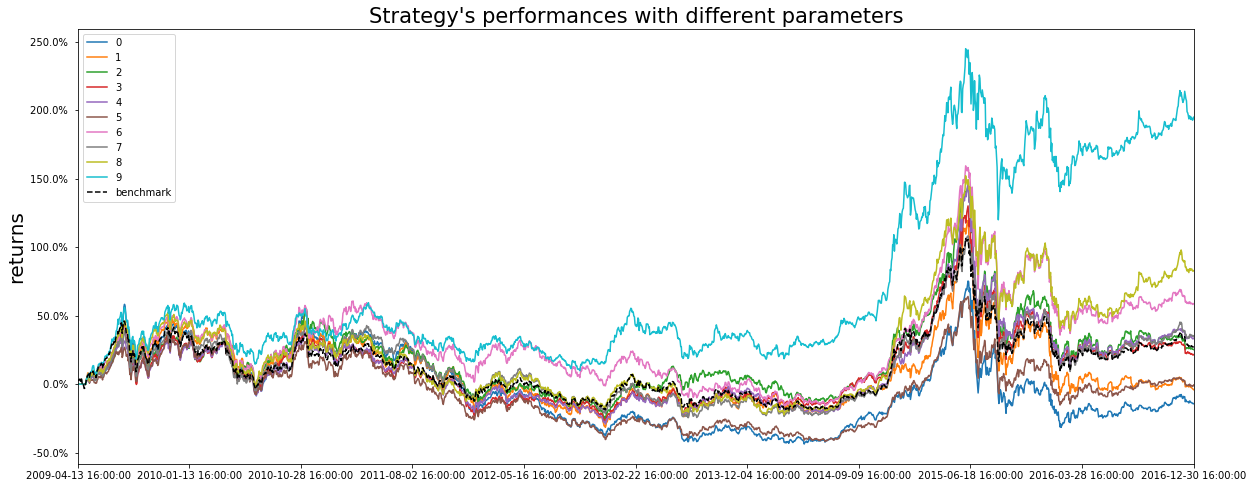

In [195]:
#7 回报率折线图    
pa.plot_returns()

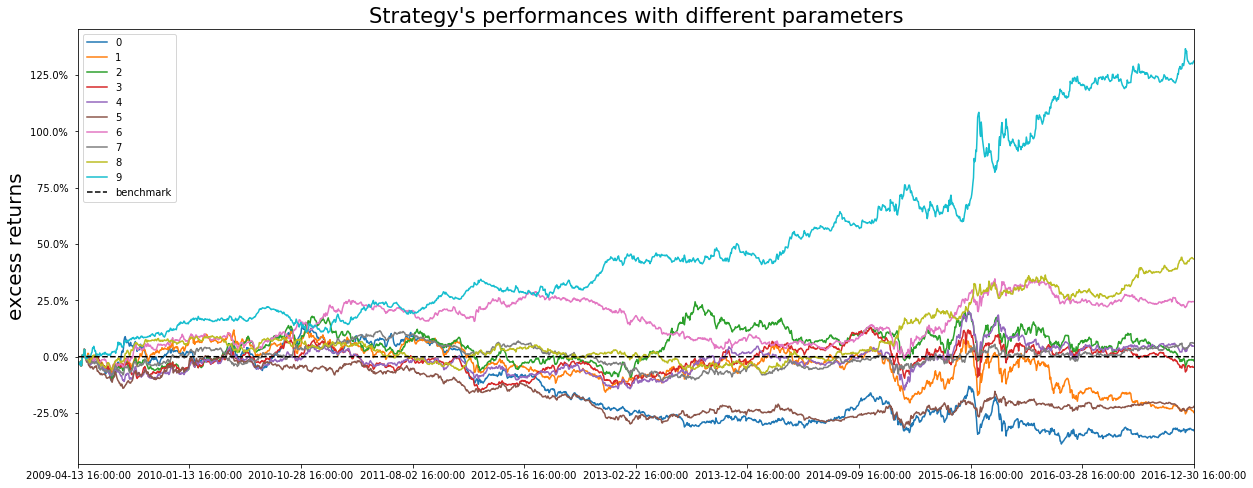

In [196]:
#8 超额收益率图    
pa.plot_excess_returns()

 total_returns total_annualized_returns benchmark_returns alpha  beta  \
        -72.1%                  -15.61%            27.53%  -0.2  0.14   

 sharpe_ratio volatility max_drawdown  
        -0.96     20.47%       73.72%  


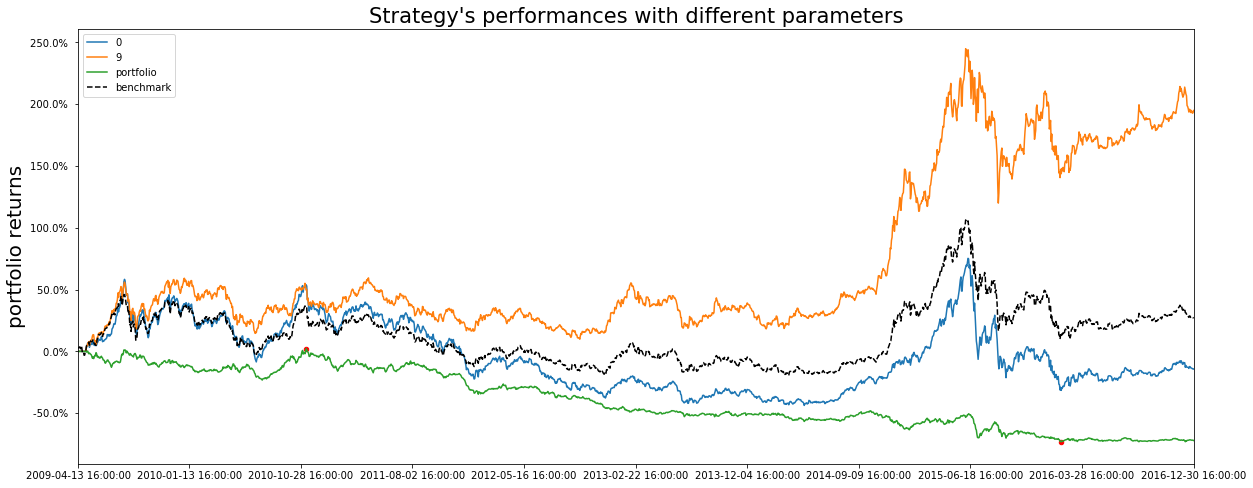

In [197]:
#9 多空组合折线图
pa.plot_long_short_portfolio_returns()


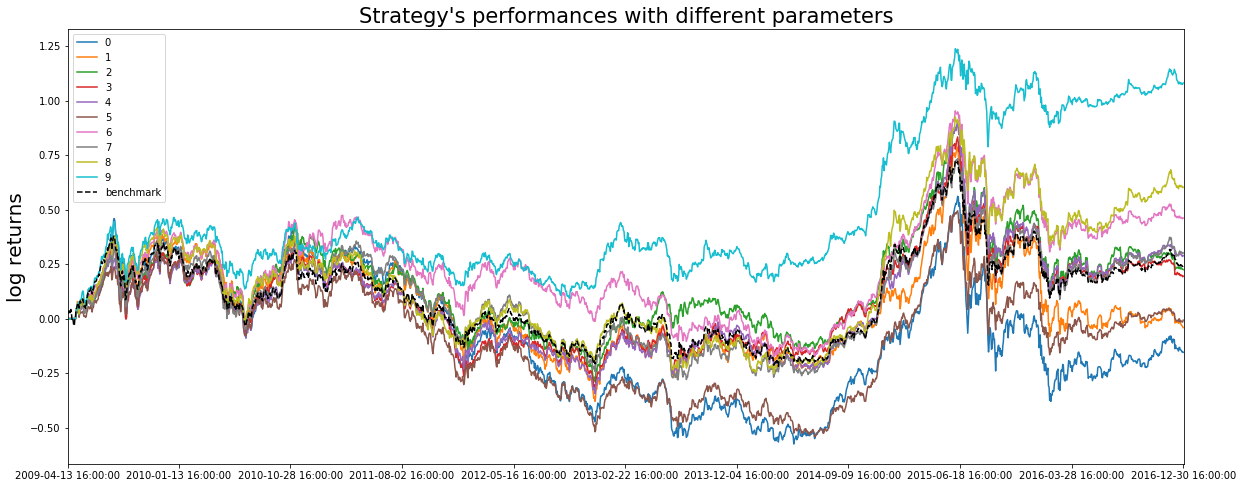

In [198]:
#10 log回报率图    
pa.plot_log_returns()

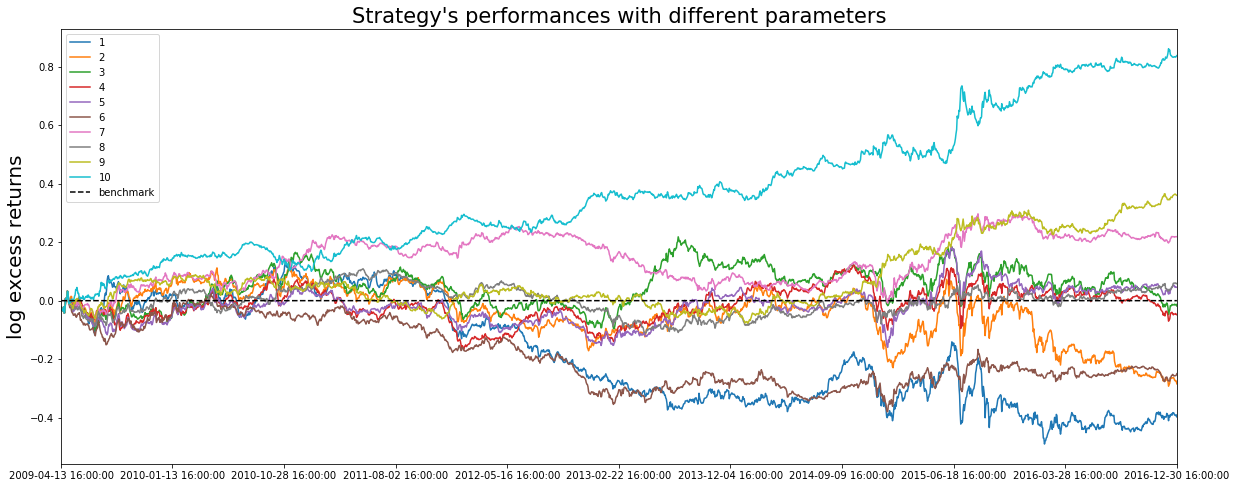

In [199]:
#11 超额收益率的 log 图
pa.plot_log_excess_returns()

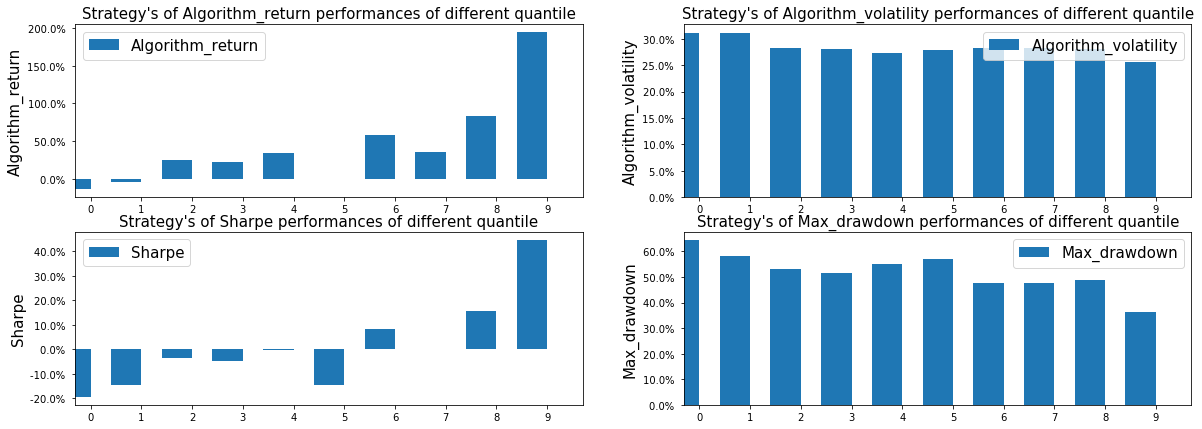

In [200]:
#12 回测的4个主要指标，包括总回报率、最大回撤夏普率和波动
# get_eval4_bar(self, sort_by=[])
pa.get_eval4_bar()

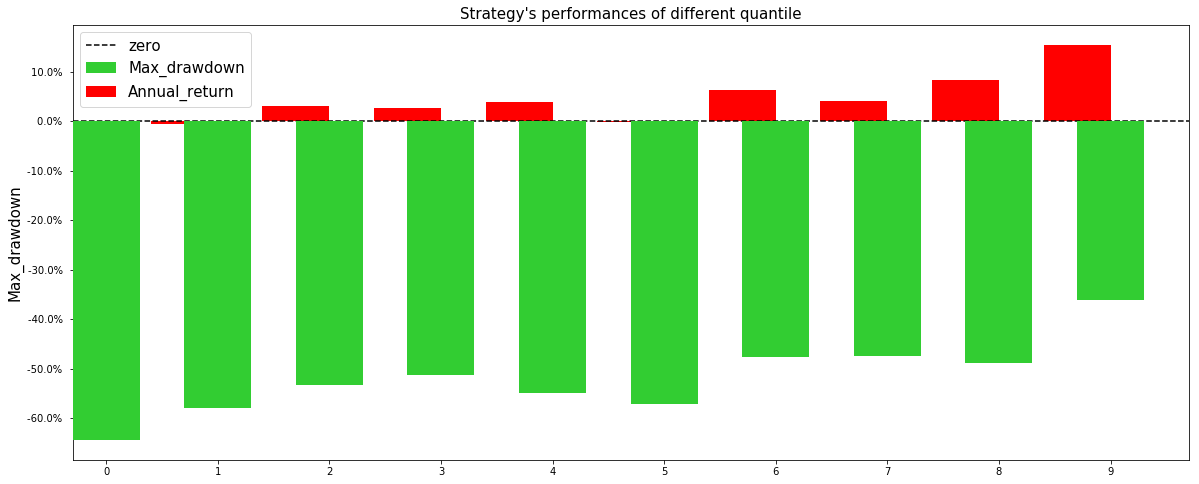

In [201]:
#13 年化回报和最大回撤，正负双色显示
# get_eval(self, sort_by=[])
pa.get_eval()

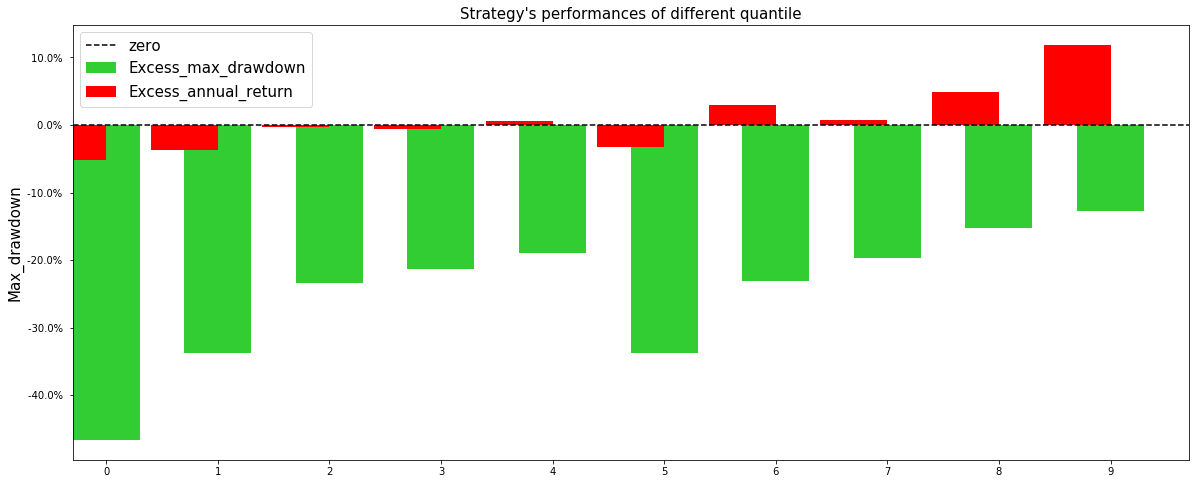

In [202]:
#14 超额收益的年化回报和最大回撤
# 加入新的benchmark后超额收益和
# get_excess_eval(self, sort_by=[])
pa.get_excess_eval()

In [203]:
# test 测试最后bar图中的sort_by对应内容
param_names=['abc','x_y_z']
param_values=[['a','b','c'], [1,2]]
param_combinations = list(itertools.product(*param_values))
to_run_df = pd.DataFrame(param_combinations)
to_run_df.columns = param_names
# to_run_df.ix[1].to_dict()
to_run_df

# sort_by = ['abc']
sort_by = ['abc', 'x_y_z']
# sort_by = ['x_y_z']
# sort_by = ['x_y_z','abc']
sorted_params = to_run_df
for by in sort_by:
    sorted_params = sorted_params.sort_values(by)
indices = sorted_params.index
sorted_params

,abc,x_y_z
0,a,1
2,b,1
4,c,1
1,a,2
3,b,2
5,c,2


In [204]:
#         first_group_cumulative_return = pa.returns[0].copy()
#         last_group_cumulative_return = pa.returns[len(pa.returns.keys())-1].copy()
#         first_group_net_value = [x+1 for x in first_group_cumulative_return]
#         last_group_net_value = [x+1 for x in last_group_cumulative_return]
        
#         #计算每日涨跌幅
#         first_group_daily_return = [(first_group_net_value[i+1]-first_group_net_value[i])/first_group_net_value[i] for i in range(len(first_group_net_value)-1)]
#         last_group_daily_return = [(last_group_net_value[i+1]-last_group_net_value[i])/last_group_net_value[i] for i in range(len(last_group_net_value)-1)]
#         portfolio_daily_return = [first_group_daily_return[i]-last_group_daily_return[i] for i in range(len(first_group_daily_return))]


# #输出并保存为csv文件
# #########################可选
# with open('C:/Users/dsquant06/Desktop/test/{0}.csv'.format('beta'),'w') as f:
#     f.write('{0},{1},{2}\n'.format('benchmark_returns','returns','time'))
#     for i in range(len(pa.results)):
#         f.write('第{0}层\n'.format(i+1))
#         for j in range(len(pa.results[i])):
#             f.write('{0},{1},{2}\n'.format(pa.results[i][j]['benchmark_returns'],pa.results[i][j]['returns'],pa.results[i][j]['time']))
#         f.write('\n\n')
#输出r日期并保存为csv文件
#########################可选


In [205]:
def date_output(path_return):
    with open(path_return,'w') as f:
        f.write('{0}\n'.format('time'))
        for j in range(len(pa.results[1])):
            f.write('{0}\n'.format(pa.results[1][j]['time']))
            
def concat_csv(path_return,factor,portfolio):
    if (os.path.exists(path_return)==False):
        date_output(path_return)

    cache=pd.DataFrame(portfolio,columns=[factor])
    cache=cache+1
    temp=pd.read_csv(path_return)
    if f in temp.columns.values:
        temp.drop(columns=f,axis=1,inplace=True)
        print("已删除"+f)
    temp=pd.concat([temp,cache],axis=1)
    if (os.path.exists(path_return)):
        os.remove(path_return)
    temp.to_csv(path_return,index=False,header=True)


In [206]:
first_group_cumulative_return = pa.returns[0].copy()
last_group_cumulative_return = pa.returns[len(pa.returns.keys())-1].copy()
first_group_net_value = [x+1 for x in first_group_cumulative_return]
last_group_net_value = [x+1 for x in last_group_cumulative_return]

#计算每日涨跌幅
first_group_daily_return = [(first_group_net_value[i+1]-first_group_net_value[i])/first_group_net_value[i] for i in range(len(first_group_net_value)-1)]
last_group_daily_return = [(last_group_net_value[i+1]-last_group_net_value[i])/last_group_net_value[i] for i in range(len(last_group_net_value)-1)]
####################################################################################
portfolio_daily_return = [first_group_daily_return[i]-last_group_daily_return[i] for i in range(len(first_group_daily_return))]

#################################################################################
#portfolio_daily_return为输出的结果，得到的为每日的回报率，计算方法为每日的（return+1）相乘最后减一
#计算累计涨跌幅
portfolio_cumulative_return = [0]
pf_net_value = [1]
net_value = 1
for i in range(len(first_group_net_value)-1):
    net_value = net_value * (1+first_group_daily_return[i]-last_group_daily_return[i])
    pf_net_value.append(net_value)
    portfolio_cumulative_return.append(net_value-1)

In [207]:
concat_csv(path,f,portfolio_cumulative_return)


In [179]:
pd.DataFrame(portfolio_cumulative_return)+1

,0
0,1.000000
1,1.000000
2,1.000000
3,1.000000
4,1.000000
5,1.000000
6,1.000000
7,1.000000
8,1.000000
9,1.000000
